<h2>Topic Extraction for Video using Machine Learning

![alternatvie text](https://s41230.pcdn.co/wp-content/uploads/2020/05/Best-Vegan-Ted-Talks.jpg)


The aim of this project is to segment and extract topics from TED Talks videos using Machine Learning and NLP techniques. The data are not labeled to train a classifier and predict categories. We therefore opt for unsupervised learning to automatically tag these videos.

This notebook focuses on studying text processing using transcripts from TED Talks. We will cover various aspects, including feature extraction and topic modeling. The objectives of this notebook are twofold: (1) to provide an introduction to text processing techniques and (2) to briefly analyze patterns within TED Talks.

The fascinating TED-Talks dataset consists of two files. The first file, ted_main.csv, contains metadata about the talks, such as the number of comments, ratings, and related TED Talks. The second file contains the transcripts, which will be the main focus of this project. However, for evaluating our topic modeling implementation, we will utilize the ted_main.csv file. It contains a column with tags assigned to the talks, which will serve as our "ground truth topics."


### Importing libraries

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading our data 


In [ ]:
ted_main_df = pd.read_csv('/content/drive/MyDrive/ted_main.csv', encoding='utf-8')
transcripts_df = pd.read_csv('/content/drive/MyDrive/transcripts.csv', encoding='utf-8')
nlp = spacy.load('en_core_web_sm')

In [ ]:
ted_main_df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [ ]:
transcripts_df.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


### Preprocessing the data 

In [ ]:
# merge the data into a single data frame
merged_df = pd.merge(transcripts_df, ted_main_df, on='url', how='inner')
merged_df.head()

,transcript,url,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,views
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,47227110
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,3200520
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,1636292
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,1697550
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,12005869


In [ ]:
# Display the result
merged_df['tags'].head()

0    ['children', 'creativity', 'culture', 'dance',...
1    ['alternative energy', 'cars', 'climate change...
2    ['computers', 'entertainment', 'interface desi...
3    ['MacArthur grant', 'activism', 'business', 'c...
4    ['Africa', 'Asia', 'Google', 'demo', 'economic...
Name: tags, dtype: object

In [ ]:
# Remove square brackets and single quotes from the 'tags' column in merged_df
merged_df['tags'] = merged_df['tags'].apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", ''))

In [ ]:
# Replace commas with spaces in the 'tags' column of merged_df
merged_df['tags'] = merged_df['tags'].apply(lambda x: str(x).replace(',', ' '))
merged_df['tags'].head()

0    children  creativity  culture  dance  educatio...
1    alternative energy  cars  climate change  cult...
2    computers  entertainment  interface design  me...
3    MacArthur grant  activism  business  cities  e...
4    Africa  Asia  Google  demo  economics  global ...
Name: tags, dtype: object

In [ ]:
# Concatenate the 'tags' and 'title' columns to the 'description' column in merged_df
merged_df['description'] += merged_df['tags'] + merged_df['title']

This function cleans the input text by removing text in parentheses, double quotes, and punctuation marks using regular expressions and spaCy. The cleaned text is returned as the output.

In [ ]:
def clean_text(text):
    text = re.sub(r'\([^)]*\)', '', text)   # remove text in parentheses
    text = re.sub('"','', text)            # remove double quotes
    doc = nlp(text)
    tokens_without_punct = [token.text for token in doc if not token.is_punct]
    text = " ".join(tokens_without_punct)
    return text

This function removes numbers and stop words from the input text, returning the cleaned text as output.

In [ ]:
def remove_numbers(text):
    # Process the text using the language model
    doc = nlp(text)

    # Remove stop words and numbers from the text
    filtered_text = [token.text for token in doc if not token.is_stop and not token.is_digit]

    # Join the filtered tokens back into a single string
    filtered_text = ' '.join(filtered_text)

    return filtered_text
  

This function performs lemmatization on the input text, returning the lemmatized version of the text. Lemmatization is the process of reducing words to their base or dictionary form, known as lemmas.

In [ ]:
def lemmatization(text):
    doc = nlp(text)
    lemma = [token.lemma_ for token in doc]
    lemma = " ".join(lemma)
    return lemma

This function removes stop words from the input text and returns the filtered text as output.

In [ ]:
def remove_stopwords(text):
    # Process the text using the language model
    doc = nlp(text)

    # Remove stop words from the text
    filtered_text = [token.text for token in doc if not token.is_stop]

    # Join the filtered tokens back into a single string
    filtered_text = ' '.join(filtered_text)

    return filtered_text

Apply these cleaning functions to our transcripts

In [ ]:
merged_df['transcripts'] = merged_df['transcript'].apply(clean_text)

In [ ]:
merged_df['transcripts'] = merged_df['transcripts'].apply(remove_numbers)

In [ ]:
merged_df['transcripts'] = merged_df['transcripts'].apply(remove_stopwords)

In [ ]:
merged_df['transcripts'][0]

"good morning you?It great ' ve blow away thing fact ' m leave theme run conference relevant want talk extraordinary evidence human creativity presentation ' ve people variety range second place idea happen term future idea play interest education actually find everybody interest education find interesting dinner party work education actually dinner party frankly work education ask ask curiously strange somebody know work education blood run face like oh God know me?my night week ask education pin wall thing deep people right like religion money thing big interest education think huge vested interest partly education mean future grasp think child start school year retire 2065 clue despite expertise parade past day world look like year time mean educate unpredictability think extraordinary ' ve agree nonetheless extraordinary capacity child capacity innovation mean Sirena night marvel exceptional think speak exceptional childhood person extraordinary dedication find talent contention ki

In [ ]:
# save the results to a temporary file            
merged_df.to_csv('/content/drive/MyDrive/merged_df.csv')

In [ ]:
merged_df.head()

,transcript,url,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,views,transcripts
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,children creativity culture dance educatio...,Do schools kill creativity?,47227110,good morning you?It great ' ve blow away thing...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,alternative energy cars climate change cult...,Averting the climate crisis,3200520,thank Chris truly great honor opportunity come...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,computers entertainment interface design me...,Simplicity sells,1636292,hello voice mail old friend ' ve tech support ...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,MacArthur grant activism business cities e...,Greening the ghetto,1697550,today ' m happy ' ve hear sustainable developm...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,Africa Asia Google demo economics global ...,The best stats you've ever seen,12005869,year ago task teach global development swedish...


### Text Preprocessing and Keyword Extraction
This section of the code focuses on preprocessing the text data and extracting keywords. It starts by importing the necessary modules, TfidfVectorizer and KMeans, from scikit-learn. Then, a TfidfVectorizer object named vectorizer is initialized with specific configuration parameters. The code uses lowercase conversion, limits the number of features to 100, sets thresholds for document frequency (max_df and min_df), considers n-grams from unigrams to trigrams, and removes English stop words. The vectorizer object is then used to transform the 'transcripts' column of the merged_df DataFrame into a matrix of TF-IDF features. Next, the feature names are retrieved from the vectorizer object, and the first feature name is printed. The TF-IDF matrix is converted into a dense matrix and the first row of the dense matrix is printed. The dense matrix is converted into a list of lists for further processing. Finally, the code extracts keywords from each document based on TF-IDF scores and stores them in the all_keywords list.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.7,
                                min_df=5,
                                ngram_range = (1,3),
                                stop_words = "english"

                            )

In [ ]:
vectors = vectorizer.fit_transform(merged_df['transcripts'])

In [ ]:
print(vectors[0])

  (0, 99)	0.03515129787962872
  (0, 44)	0.031641849165566345
  (0, 63)	0.0346514097392471
  (0, 93)	0.0610671840626173
  (0, 41)	0.034942910437271435
  (0, 62)	0.034994801470775626
  (0, 64)	0.03830580554546822
  (0, 68)	0.038122323851360246
  (0, 28)	0.027850500386306723
  (0, 11)	0.14719627196770818
  (0, 90)	0.038657104144813444
  (0, 27)	0.042896872149794964
  (0, 66)	0.0710071470758279
  (0, 98)	0.07685816165521836
  (0, 46)	0.11245024761879717
  (0, 29)	0.11877999913506104
  (0, 96)	0.20762152900251335
  (0, 61)	0.10835176619674186
  (0, 79)	0.03513384800939555
  (0, 52)	0.02808100746563683
  (0, 31)	0.11467214266006207
  (0, 95)	0.044068049902107685
  (0, 10)	0.1268585039888225
  (0, 45)	0.06606875482753251
  (0, 23)	0.03667504748997141
  :	:
  (0, 9)	0.03323931246672485
  (0, 71)	0.04130851647356622
  (0, 60)	0.10640418536802504
  (0, 88)	0.10125906057390506
  (0, 43)	0.20548242495957786
  (0, 49)	0.09518919888443513
  (0, 51)	0.3767826340005476
  (0, 70)	0.036883584998086236
 

In [ ]:
feature_names = vectorizer.get_feature_names_out() 

In [ ]:
print (feature_names[0])

000


In [ ]:
dense = vectors.todense()

In [ ]:
print(dense[0])

[[0.         0.         0.03151075 0.08670989 0.06819511 0.03573597
  0.         0.06930282 0.08821738 0.03323931 0.1268585  0.14719627
  0.06584981 0.         0.         0.         0.         0.
  0.34328364 0.         0.         0.09004633 0.         0.03667505
  0.         0.         0.         0.04289687 0.0278505  0.11878
  0.         0.11467214 0.0764481  0.09176681 0.         0.
  0.         0.23718596 0.08716966 0.14323212 0.         0.03494291
  0.03635703 0.20548242 0.03164185 0.06606875 0.11245025 0.22713076
  0.15150044 0.0951892  0.         0.37678263 0.02808101 0.
  0.         0.16415774 0.         0.         0.11505539 0.05710051
  0.10640419 0.10835177 0.0349948  0.03465141 0.03830581 0.04339411
  0.07100715 0.09621088 0.03812232 0.         0.03688358 0.04130852
  0.08912474 0.1159088  0.09422816 0.         0.06316695 0.
  0.         0.03513385 0.07256589 0.14081496 0.38908897 0.09886836
  0.         0.         0.         0.         0.10125906 0.
  0.0386571  0.        

In [ ]:
denselist = dense.tolist()

In [ ]:
all_keywords = []
for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)

In [ ]:
print ("Original Text:")
print (merged_df['transcript'][0]+"\n")

print ("Cleaned Text:")
print (merged_df['transcripts'][0]+"\n")

print ("Only Keywords Text:")
print (all_keywords[0])

Original Text:
Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here. Just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — Actually, you're not often at dinner parties, frankly.(Laughter)If you work in education, you're not asked.(Laughter)And you're never asked back, curiously. That's strange to me. But if you are, and you say to somebody, yo

### Determining the Optimal Number of Clusters with Silhouette Analysis
This part of the code focuses on determining the optimal number of clusters using silhouette analysis. It begins by importing the silhouette_score function from sklearn.metrics. Then, a range of cluster numbers is defined. For each cluster number in the range, the K-Means algorithm is applied to the TF-IDF vectors. The silhouette score is calculated using the Euclidean distance metric, and the scores are stored in the silhouette_scores list. The cluster number with the highest silhouette score is identified as the optimal number of clusters. The code plots the silhouette scores against the range of cluster numbers to visualize the results. Finally, the optimal number of clusters and its corresponding silhouette score are printed.

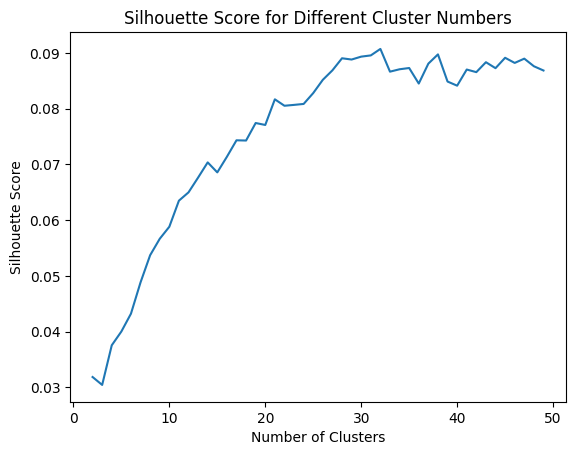

Optimal number of clusters: 32
Optimal score : 0.09074430798530853


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
cluster_range = range(2, 50)  # Adjust the range of cluster numbers

for true_k in cluster_range:
    model_km = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1,random_state=15)
    model_km.fit(vectors)
    cluster_labels = model_km.labels_
    silhouette_avg = silhouette_score(vectors, cluster_labels,metric='euclidean')
    silhouette_scores.append(silhouette_avg)

optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]

# Plot the silhouette scores
plt.plot(cluster_range, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Cluster Numbers')
plt.show()

print("Optimal number of clusters:", optimal_num_clusters)
print("Optimal score :",np.max(silhouette_scores))

### Text Clustering and Top Keywords for Each Cluster
This section of the code performs text clustering using K-Means with the optimal number of clusters determined earlier. The K-Means algorithm is applied to the TF-IDF vectors using the KMeans class from scikit-learn. The cluster centroids are sorted in descending order to obtain the most important terms for each cluster. The feature names (terms) are retrieved from the vectorizer object. The code then iterates over each cluster and prints the cluster number along with the top 10 keywords for that cluster. Additionally, a separate clustering is performed with a fixed number of 5 clusters to compare the results.

In [ ]:
model = KMeans(n_clusters=optimal_num_clusters, init="k-means++", max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

In [ ]:
i = 0
for cluster in order_centroids:
    print (f"Cluster {i}")
    for keyword in cluster[0:10]:
        print (terms[keyword])
    print ("")
    i=i+1

Cluster 0
guy
hand
let
kind
great
point
try
place
kid
bad

Cluster 1
country
percent
change
problem
today
create
live
let
million
believe

Cluster 2
computer
information
build
sort
kind
technology
different
change
try
create

Cluster 3
feel
experience
moment
change
live
learn
story
ask
try
great

Cluster 4
000
million
number
big
long
try
study
ago
place
percent

Cluster 5
city
build
community
space
place
live
design
car
change
create

Cluster 6
light
space
turn
away
love
learn
big
place
idea
create

Cluster 7
space
car
idea
create
technology
build
big
small
today
different

Cluster 8
ask
family
live
feel
question
old
friend
believe
learn
home

Cluster 9
kind
sort
idea
try
problem
different
let
bit
big
question

Cluster 10
man
woman
feel
story
old
great
love
face
ask
let

Cluster 11
brain
human
feel
idea
experience
different
kind
body
face
example

Cluster 12
design
kind
build
create
technology
idea
project
change
human
different

Cluster 13
water
place
big
try
problem
grow
live
percent

In [ ]:
model = KMeans(n_clusters=5, init="k-means++", max_iter=100, n_init=1)

In [ ]:
model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

In [ ]:
i = 0
for cluster in order_centroids:
    print (f"Cluster {i}")
    for keyword in cluster[0:10]:
        print (terms[keyword])
    print ("")
    i=i+1

Cluster 0
water
city
cell
light
space
build
car
place
body
design

Cluster 1
country
problem
change
kind
technology
percent
datum
idea
let
big

Cluster 2
play
hear
feel
kind
let
love
kid
try
different
idea

Cluster 3
feel
story
love
brain
child
kid
man
school
live
human

Cluster 4
woman
man
child
story
country
feel
family
old
live
school



### Visualization of Text Clustering Results using PCA and Scatter Plot
This code snippet focuses on visualizing the results of text clustering using Principal Component Analysis (PCA) and a scatter plot. It begins by importing the necessary modules, including matplotlib.pyplot for plotting and sklearn.decomposition.PCA for dimensionality reduction. The fit_predict method of the model object is used to assign cluster indices to the TF-IDF vectors.

Next, PCA is applied to reduce the dimensionality of the TF-IDF vectors to 2D, enabling visualization. The fit_transform method is called on the vectors array after converting it to a dense representation using the toarray() method.

The code defines a list of colors for different clusters. It then extracts the x-axis and y-axis coordinates from the transformed scatter plot points.

A scatter plot is created using matplotlib.pyplot.scatter, where the x-axis represents the first principal component and the y-axis represents the second principal component. 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# Perform clustering using the K-Means model and assign cluster indices to the vectors
kmean_indices = model.fit_predict(vectors)

# Perform Principal Component Analysis (PCA) for dimensionality reduction to 2 components
pca = PCA(n_components=2)
# Transform the vectors to 2D using PCA
scatter_plot_points = pca.fit_transform(vectors.toarray())


In [ ]:
colors = ["r", "b", "m", "y", "c"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

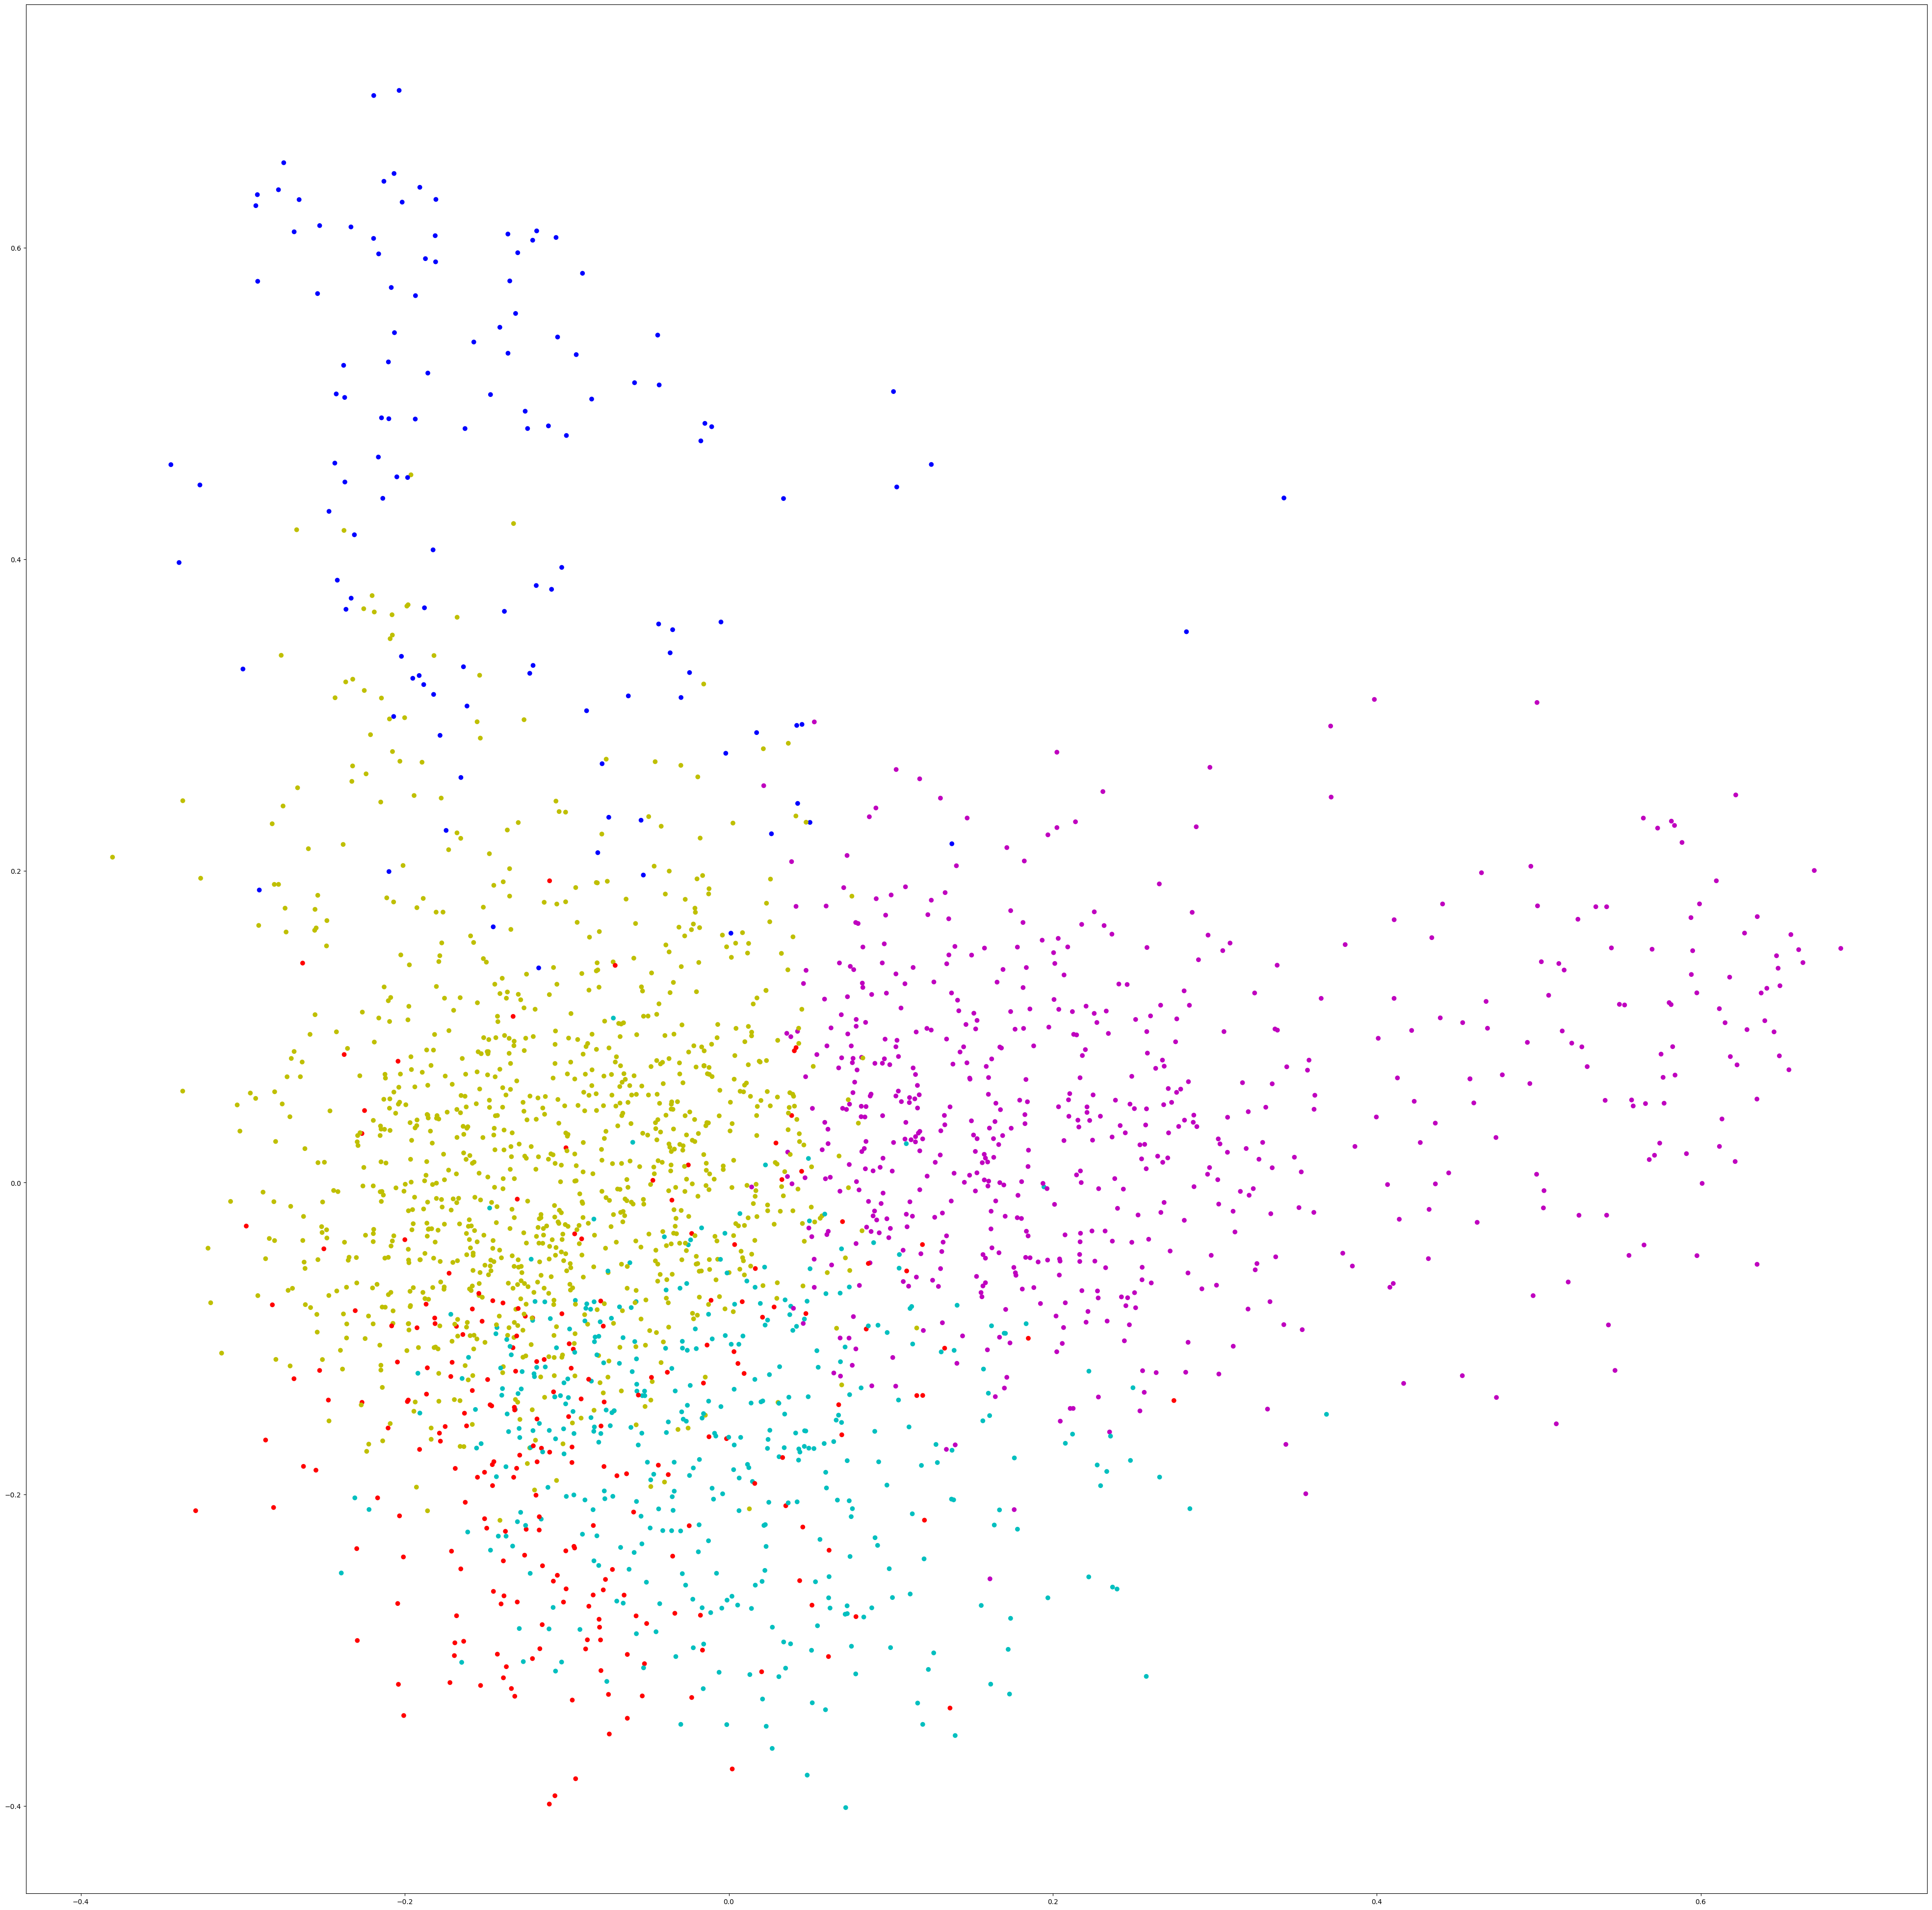

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])

<h2> Topic Modeling and Visualization using Latent Dirichlet Allocation (LDA) with TF-IDF Preprocessing

### Text Preprocessing and Lemmatization
We focus here on preprocessing the text data and performing lemmatization. The merged_df DataFrame is loaded from a CSV file containing transcripts. The code defines a lemmatization function that takes a list of texts and applies lemmatization using spaCy. Only tokens with allowed part-of-speech tags (NOUN, ADJ, VERB, ADV) are retained. Another function, gen_words, applies simple preprocessing using Gensim's simple_preprocess method. The lemmatized_texts list is created by applying lemmatization to the 'transcript' column of the merged_df DataFrame. Similarly, the data_words list is generated by applying simple preprocessing to the lemmatized texts.

In [5]:
# Importing and reading the data 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
merged_df = pd.read_csv('transcripts.csv')

In [7]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

lemmatized_texts = lemmatization(merged_df['transcript'])
data_words = gen_words(lemmatized_texts)

#print (data_words[0][0:20])

### TF-IDF Transformation and Low-Value Word Filtering
In this section, the code performs TF-IDF transformation on the preprocessed texts. A Gensim Dictionary object, id2word, is created using the data_words list. The corpus is constructed by converting each text in data_words into a Bag-of-Words representation using the id2word dictionary. TF-IDF transformation is then applied to the corpus using Gensim's TfidfModel.

Next, We filter out low-value words based on a specified threshold (low_value). The code iterates over each document in the corpus, identifies words with TF-IDF values below the threshold, and removes them from the document's Bag-of-Words representation. Additionally, it keeps track of words missing in the TF-IDF model to avoid removing them in subsequent iterations.

In [8]:
from gensim.models import TfidfModel
id2word = corpora.Dictionary(data_words)


corpus = [id2word.doc2bow(text) for text in data_words]

# Create a TF-IDF model using Gensim's TfidfModel
tfidf = TfidfModel(corpus, id2word=id2word)

# Set a threshold value for low-value words
low_value = 0.03

# Initialize lists to store low-value words and words missing in TF-IDF
words = []
words_missing_in_tfidf = []

# Iterate over each document in the corpus
for i in range(0, len(corpus)):
    bow = corpus[i]  # Retrieve the Bag-of-Words representation of the document
    low_value_words = []  # Initialize list for low-value words
    
    # Get the TF-IDF ids and Bag-of-Words ids
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    
    # Identify low-value words based on TF-IDF values below the threshold
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    
    # Combine low-value words with words missing in TF-IDF
    drops = low_value_words + words_missing_in_tfidf
    
    # Add words to the list for removal
    for item in drops:
        words.append(id2word[item])
    
    # Find words missing in TF-IDF by comparing Bag-of-Words ids with TF-IDF ids
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    # Create a new Bag-of-Words representation without low-value words and words missing in TF-IDF
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow  # Replace the original Bag-of-Words representation with the new one


### Latent Dirichlet Allocation (LDA) Topic Modeling
This part of the code focuses on performing topic modeling using Latent Dirichlet Allocation (LDA). The LDA model is instantiated using the Gensim LdaModel class, which takes the preprocessed corpus, the id2word dictionary, and other parameters such as the number of topics, random state, update frequency, and passes. The resulting LDA model is saved to a file named "test_model.model" and then loaded back into a new_model object.

A test document, test_doc, is selected from the corpus. The LDA model is used to obtain the topic vector representation of the test document, which is printed. The code also includes a utility function, Sort, that sorts the topic vector in descending order based on the topic probabilities and prints the sorted vector.

The total number of unique words in the id2word dictionary is printed. Finally, the code utilizes the pyLDAvis library to create an interactive visualization of the LDA model. The pyLDAvis.gensim.prepare function prepares the data for visualization by computing various metrics and returns an interactive visualization object (vis) that can be displayed in the Jupyter Notebook.

In [9]:
# Create an LDA model using Gensim's LdaModel
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus[:-1],  # Specify the corpus (excluding the last document)
    id2word=id2word,  # Specify the mapping of word ids to words
    num_topics=10,  # Specify the number of topics to extract
    random_state=100,  # Set the random state for reproducibility
    update_every=1,  # Set the number of documents to process before updating the model
    chunksize=100,  # Set the number of documents to be used in each training chunk
    passes=10,  # Set the number of passes through the corpus during training
    alpha="auto"  # Set the hyperparameter alpha for automatic topic distribution
)

In [10]:
# Save the results
lda_model.save("test_model.model")

In [11]:
# Load the LDA model from "test_model.model"
new_model = gensim.models.ldamodel.LdaModel.load("test_model.model")

In [12]:
# Retrieve the last document from the corpus and assign it to the variable 'test_doc'
test_doc = corpus[-1]

# Obtain the topic distribution for the test document using the loaded LDA model
vector = new_model[test_doc]

# Print the topic distribution vector
print(vector)

# Define a function 'Sort' to sort a list of tuples based on the second element in descending order
def Sort(sub_li):
    sub_li.sort(key=lambda x: x[1])
    return sub_li[::-1]


[(0, 0.06482072), (1, 0.11921419), (2, 0.010253129), (3, 0.20661108), (5, 0.03314147), (6, 0.39945185), (7, 0.045107305), (8, 0.09303927), (9, 0.027153078)]


In [13]:
# Sort the topic distribution vector using the 'Sort' function defined previously
new_vector = Sort(vector)

# Print the sorted topic distribution
print(new_vector)

[(6, 0.39945185), (3, 0.20661108), (1, 0.11921419), (8, 0.09303927), (0, 0.06482072), (7, 0.045107305), (5, 0.03314147), (9, 0.027153078), (2, 0.010253129)]


In [14]:
len(id2word.values())

32129

In [15]:
import pyLDAvis
import pyLDAvis.gensim

# Enable interactive visualization in the notebook
pyLDAvis.enable_notebook()

# Generate the interactive visualization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.197704  0.095793       1        1  15.849582
8      0.094579 -0.089690       2        1  15.753818
5      0.224954  0.088690       3        1  14.772241
9      0.178004 -0.266988       4        1   9.429886
3     -0.066346  0.036631       5        1   9.396788
1     -0.005051  0.264570       6        1   8.720958
6     -0.079048  0.059428       7        1   8.527676
0     -0.133309 -0.177337       8        1   7.380891
4     -0.156823 -0.009039       9        1   6.064206
2     -0.254664 -0.002057      10        1   4.103955, topic_info=         Term         Freq        Total Category  logprob  loglift
62      brain  2663.000000  2663.000000  Default  30.0000  30.0000
550     woman  3559.000000  3559.000000  Default  29.0000  29.0000
621      city  2507.000000  2507.000000  Default  28.0000  28.0000
649   country  2593.000000  2593.000000  Default  27.0000  27.0000
955      cell  1881.000000  1881.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
202      grow   376.639394   661.375043  Topic10  -4.5422   2.6302
3231     bird   241.427767   328.588954  Topic10  -4.9869   2.8850
542     water   562.773647  1918.577911  Topic10  -4.1406   1.9668
2051   nature   329.575984   675.909696  Topic10  -4.6757   2.4750
388   produce   276.203678   740.746661  Topic10  -4.8524   2.2067

[576 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1723      2  0.368396      able
1723      5  0.140408      able
1723      6  0.031974      able
1723      9  0.458757      able
1304      4  0.994587  activist
...     ...       ...       ...
563       6  0.993451       yet
909       1  0.232277     young
909       3  0.726665     young
909       4  0.039423     young
3471      5  0.993556      zoom

[953 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 6, 10, 4, 2, 7, 1, 5, 3])